In [1]:
from sklearn.datasets import load_digits

# basic liraries
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import plotly.plotly as py
%matplotlib inline

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso, LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import learning_curve, train_test_split, KFold
from sklearn.metrics import make_scorer, mean_squared_error

from hybrid_linear_tree2 import *
# from hybrid_tree import *
from sklearn.ensemble import BaggingRegressor

import os, re
import time
import pickle

import warnings
warnings.filterwarnings('ignore')

## 0. Dataset (PIK Digital day)

In [2]:
dataset_name = 'pik_train'

In [3]:
df_pik = pd.read_csv(dataset_name + '.csv', encoding='cp1251')

columns = [
    'id', 'id_bulk', 'spalen', 'date1', 'start_square', 'value', 'price', 
    'mean_sq', 'mean_fl', 'plan_s', 'plan_m', 'plan_l', 'vid_0', 'vid_1', 
    'vid_2', 'month', 'month_cnt', 'class_objecta', 'kolichestvo_pomecheniy', 
    'ogorojena_territoriya', 'plochad_zemelnogo_uchastka', 'vhodnie_gruppi',
    'detskiy_sad', 'school', 'hospital', 'fok', 'sportivnaya_plochadka',
    'avtomoika', 'kladovie', 'kolyasochnie', 'kondei', 'ventilaciya', 'lift',
    'sistema_musora_otvedeniya', 'videonabludenie', 'podzemnaiya_parkovka',
    'dvor_bez_machin', 'machinomesta', 'plochad_promzoni_radius_500_m',
    'plochad_zelenoy_zoni_radius_500_m', 'do_kremliya_km', 'do_ttk_km',
    'do_sadovogo_km', 'do_bolchoy_dorogi_na_machine',
    'do_udobnoy_avtorazviyazki_km', 'do_metro_pechkom_km', 'do_promki_km',
    'do_parka_km', 'do_parka_pechkom_km','stanciy_metro_ot_kolca',
    'plochad_dvora', 'kurs', 'stavka_po_ipoteke', 'vkladi_ot_1_goda',
    'vkladi_ot_1do_3_let', 'vkladi_sviche_3_let'
]
df_pik.columns = columns

# Ненужные или Нет в тестовых данных
df_pik.drop(['id', 'sistema_musora_otvedeniya', 'start_square', 'plan_s', 'plan_m', 'plan_l', 'vid_0', 'vid_1', 'vid_2'], 
        axis=1, inplace=True)

In [4]:
# convert string columns to binary

df_pik['econom'] = 0
df_pik['comfort'] = 0
df_pik['standart'] = 0

for index, row in df_pik.iterrows():
    class_obj = row['class_objecta']
    if class_obj == 'комфорт':
        df_pik.loc[index, 'comfort'] = 1
    elif class_obj == 'эконом':
        df_pik.loc[index, 'econom'] = 1
    else:
        df_pik.loc[index, 'standart'] = 1


# 2. Заменим "да" и "нет" на 1 и 0 соответсвенно в столбцах ogorojena_territoriya, avtomoika, kladovie, 
# kolyasochnie, podzemnaiya_parkovka, dvor_bez_machin, sportivnaya_plochadka и vhodnie_gruppi.

for col in ['ogorojena_territoriya', 'avtomoika', 'kladovie'\
            ,'kolyasochnie', 'podzemnaiya_parkovka', 'dvor_bez_machin', 'sportivnaya_plochadka', 'vhodnie_gruppi']:
    df_pik[col] = df_pik[col].apply(lambda elem: 1 if elem == 'да' else 0)

df_pik.drop('class_objecta', axis = 1, inplace = True)

df_pik.set_index(['date1', 'id_bulk'], inplace = True)

In [5]:
X = df_pik.drop('value', axis = 1)
y = df_pik['value']

In [6]:
X.shape

(8726, 46)

## 1. Pipeline

### 1.1 Lasso

In [47]:
start_time = time.time()
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)  # лучше cv = 10

scl = StandardScaler(with_mean = True, with_std = True)
model = Lasso(max_iter = 5000, tol = 1e-3, random_state= 42)

pipe = Pipeline(
    steps = [
         ('scl', scl),
         ('model', model)
    ]
)

param_grid = { 
    'model__alpha': [1, 5, 10]
}

gs_lasso = GridSearchCV(
    pipe, 
    param_grid,
    cv = cv,
    scoring = 'neg_mean_squared_error'
)

gs_lasso.fit(X, y)

train_MSE = (-gs_lasso.cv_results_['mean_train_score'][gs_lasso.cv_results_['rank_test_score'] == 1]).mean()
train_std = (gs_lasso.cv_results_['std_train_score'][gs_lasso.cv_results_['rank_test_score'] == 1]).mean()

cv_MSE = (-gs_lasso.cv_results_['mean_test_score'][gs_lasso.cv_results_['rank_test_score'] == 1]).mean()
cv_std = (gs_lasso.cv_results_['std_test_score'][gs_lasso.cv_results_['rank_test_score'] == 1]).mean()

print('train MSE: {} +/- {}'.format(np.round(train_MSE, 2), np.round(train_std, 2)))
print('CV MSE: {} +/- {}'.format(np.round(cv_MSE, 2), np.round(cv_std, 2)))
print(gs_lasso.best_params_)
print('time: {} min'.format(np.round((time.time() - start_time)/60, 2))) 

filename = dataset_name + '_Lasso.sav'
pickle.dump(gs_lasso, open(filename, 'wb'))

train MSE: 109941.22 +/- 3745.85
CV MSE: 111229.38 +/- 15783.3
{'model__alpha': 1}
time: 0.05 min


### 1.2 Decision Tree

In [48]:
start_time = time.time()

model = DecisionTreeRegressor(criterion='mse', random_state = 42)

cv = KFold(n_splits = 5, shuffle = True, random_state = 42)  # лучше cv = 10
param_grid = {
    'max_depth': [30, 40, 50],
    'min_samples_leaf': [3],  # Минимальное число наблюдений в листе
    'min_impurity_decrease' : [3],  # Минимальный прирост MSE при разделении в вершине на 2 ветки
}
gs_tree = GridSearchCV(model, param_grid, cv = cv, scoring = 'neg_mean_squared_error')
gs_tree.fit(X, y)

train_MSE = (-gs_tree.cv_results_['mean_train_score'][gs_tree.cv_results_['rank_test_score'] == 1]).mean()
train_std = (gs_tree.cv_results_['std_train_score'][gs_tree.cv_results_['rank_test_score'] == 1]).mean()

cv_MSE = (-gs_tree.cv_results_['mean_test_score'][gs_tree.cv_results_['rank_test_score'] == 1]).mean()
cv_std = (gs_tree.cv_results_['std_test_score'][gs_tree.cv_results_['rank_test_score'] == 1]).mean()

print('train MSE: {} +/- {}'.format(np.round(train_MSE, 2), np.round(train_std, 2)))
print('CV MSE: {} +/- {}'.format(np.round(cv_MSE, 2), np.round(cv_std, 2)))
print(gs_tree.best_params_)
print('time :{} min'.format(np.round((time.time() - start_time)/60, 2))) 

filename = dataset_name + '_DecisionTree.sav'
pickle.dump(gs_tree, open(filename, 'wb'))

train MSE: 19271.28 +/- 879.54
CV MSE: 93506.16 +/- 14661.06
{'max_depth': 30, 'min_impurity_decrease': 3, 'min_samples_leaf': 3}
time :0.03 min


### 1.3 Random Forest

In [49]:
start_time = time.time()

model = RandomForestRegressor(criterion='mse', random_state = 42)

cv = KFold(n_splits = 5, shuffle = True, random_state = 42)  # лучше cv = 10
param_grid = {
    'n_estimators': [100],
    'max_depth': [20, 30],
    'min_samples_leaf': [3],  # Минимальное число наблюдений в листе
    'min_impurity_decrease' : [3],  # Минимальный прирост MSE при разделении в вершине на 2 ветки
    'max_features': [0.7]  # 1, 0.7 - доля от всех фичей
}
gs_rf = GridSearchCV(model, param_grid, cv = cv, scoring = 'neg_mean_squared_error')
gs_rf.fit(X, y)

train_MSE = (-gs_rf.cv_results_['mean_train_score'][gs_rf.cv_results_['rank_test_score'] == 1]).mean()
train_std = (gs_rf.cv_results_['std_train_score'][gs_rf.cv_results_['rank_test_score'] == 1]).mean()

cv_MSE = (-gs_rf.cv_results_['mean_test_score'][gs_rf.cv_results_['rank_test_score'] == 1]).mean()
cv_std = (gs_rf.cv_results_['std_test_score'][gs_rf.cv_results_['rank_test_score'] == 1]).mean()

print('train RMSE: {} +/- {}'.format(np.round(train_MSE, 2), np.round(train_std, 2)))
print('CV RMSE: {} +/- {}'.format(np.round(cv_MSE, 2), np.round(cv_std, 2)))
print(gs_rf.best_params_)
print('time :{} min'.format(np.round((time.time() - start_time)/60, 2))) 

filename = dataset_name + '_RF.sav'
pickle.dump(gs_rf, open(filename, 'wb'))

train RMSE: 23616.16 +/- 877.3
CV RMSE: 59241.94 +/- 9051.58
{'max_depth': 30, 'max_features': 0.7, 'min_impurity_decrease': 3, 'min_samples_leaf': 3, 'n_estimators': 100}
time :1.16 min


### 1.4  ExtraTreeRegressor

In [50]:
start_time = time.time()

model = ExtraTreesRegressor(criterion='mse',
                              random_state = 42)

cv = KFold(n_splits = 5, shuffle = True, random_state = 42)  # лучше cv = 10
param_grid = {
             'n_estimators': [100],
             'max_depth': [20, 30],
             'min_samples_leaf': [3],  # Минимальное число наблюдений в листе
             'min_impurity_decrease' : [3],  # Минимальный прирост MSE при разделении в вершине на 2 ветки
             'max_features': [0.7]  # 1, 0.7 - доля от всех фичей
             }
gs_etr = GridSearchCV(model, param_grid,
                 cv = cv,
                 scoring = 'neg_mean_squared_error')
gs_etr.fit(X, y)

train_MSE = (-gs_etr.cv_results_['mean_train_score'][gs_etr.cv_results_['rank_test_score'] == 1]).mean()
train_std = (gs_etr.cv_results_['std_train_score'][gs_etr.cv_results_['rank_test_score'] == 1]).mean()

cv_MSE = (-gs_etr.cv_results_['mean_test_score'][gs_etr.cv_results_['rank_test_score'] == 1]).mean()
cv_std = (gs_etr.cv_results_['std_test_score'][gs_etr.cv_results_['rank_test_score'] == 1]).mean()

print('train MSE: {} +/- {}'.format(np.round(train_MSE, 2), np.round(train_std, 2)))
print('CV MSE: {} +/- {}'.format(np.round(cv_MSE, 2), np.round(cv_std, 2)))
print(gs_etr.best_params_)
print('time :{} min'.format(np.round((time.time() - start_time)/60, 2))) 

filename = dataset_name + '_ExtraTreeRegressor.sav'
pickle.dump(gs_etr, open(filename, 'wb'))

train MSE: 19856.22 +/- 986.25
CV MSE: 56203.49 +/- 6918.45
{'max_depth': 30, 'max_features': 0.7, 'min_impurity_decrease': 3, 'min_samples_leaf': 3, 'n_estimators': 100}
time :0.51 min


### 1.5 HRT

In [7]:
int(0.05*len(X))

436

In [40]:
start_time = time.time()

model = HybridRegressionTree()

cv = KFold(n_splits=5, shuffle=True, random_state=42)  # лучше cv = 10

param_grid = {
    'mode': ['Lasso'],
    'min_node_size': [int(p*len(X)) for p in [0.03, 0.1, 0.3]],
    'min_split_improvement': [10, 20]
}

gs_hrt = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
gs_hrt.fit(X, y.values)

train_MSE = (-gs_hrt.cv_results_['mean_train_score'][gs_hrt.cv_results_['rank_test_score'] == 1]).mean()
train_std = (gs_hrt.cv_results_['std_train_score'][gs_hrt.cv_results_['rank_test_score'] == 1]).mean()

cv_MSE = (-gs_hrt.cv_results_['mean_test_score'][gs_hrt.cv_results_['rank_test_score'] == 1]).mean()
cv_std = (gs_hrt.cv_results_['std_test_score'][gs_hrt.cv_results_['rank_test_score'] == 1]).mean()

print('train MSE: {} +/- {}'.format(np.round(train_MSE, 2), np.round(train_std, 2)))
print('CV MSE: {} +/- {}'.format(np.round(cv_MSE, 2), np.round(cv_std, 2)))
print(gs_hrt.best_params_)
print('time :{} min'.format(np.round((time.time() - start_time)/60, 2))) 

filename = dataset_name + '_HybridRegressionTree.sav'
pickle.dump(gs_hrt, open(filename, 'wb'))

train MSE: 63887.73 +/- 2060.34
CV MSE: 85543.67 +/- 9519.01
{'min_node_size': 261, 'min_split_improvement': 10, 'mode': 'Lasso'}
time :7.77 min


In [8]:
start_time = time.time()

min_samples_node_list = [int(0.01*X.shape[0]), int(0.05*X.shape[0]),\
                         int(0.1*X.shape[0]), int(0.2*X.shape[0]), int(0.3*X.shape[0])]
min_split_threshold_list = [10, 10, 10, 15, 20, 20]

scores_hrt_df = pd.DataFrame(columns=['min_samples_leaf', 'min_impurity_decrease', 
                     'fold1', 'fold2', 'fold3', 'fold4', 'fold5'])


for min_samples_node, min_split_threshold  in zip(min_samples_node_list, min_split_threshold_list):
    
    hrt = HybridRegressionTree(min_node_size = min_samples_node, 
                               mode='Lasso', 
                               min_split_improvement=min_split_threshold)
    
    kf = KFold(n_splits=5, random_state=42)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        hrt.fit(X_train, y_train.values)
        y_pred = hrt.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(rmse)
        
    scores_hrt_df_tmp = pd.DataFrame([[min_samples_node, min_split_threshold] + scores], 
                                 columns=['min_samples_leaf', 'min_impurity_decrease', \
                                             'fold1', 'fold2', 'fold3', 'fold4', 'fold5'])
    scores_hrt_df = scores_hrt_df.append(scores_hrt_df_tmp)


# cv_MSE = (-gs_hrt.cv_results_['mean_test_score'][gs_hrt.cv_results_['rank_test_score'] == 1]).mean()
# cv_std = (gs_hrt.cv_results_['std_test_score'][gs_hrt.cv_results_['rank_test_score'] == 1]).mean()

# print('train MSE: {} +/- {}'.format(np.round(train_MSE, 2), np.round(train_std, 2)))
# print('CV MSE: {} +/- {}'.format(np.round(cv_MSE, 2), np.round(cv_std, 2)))
# print(gs_hrt.best_params_)
# print('time :{} min'.format(np.round((time.time() - start_time)/60, 2))) 

# filename = dataset_name + '_HRT.sav'
# pickle.dump(gs_hrt, open(filename, 'wb'))

FUCK
FUCK
FUCK
FUCK
FUCK


In [9]:
scores_hrt_df['RMSE'] = scores_hrt_df[['fold1', 'fold2', 'fold3', 'fold4', 'fold5']].mean(axis = 1).values
scores_hrt_df['RMSE_std'] = scores_hrt_df[['fold1', 'fold2', 'fold3', 'fold4', 'fold5']].std(axis = 1).values

In [10]:
scores_hrt_df.head(5)

,min_samples_leaf,min_impurity_decrease,fold1,fold2,fold3,fold4,fold5,RMSE,RMSE_std
0,87,10,1346.685369,1661.937938,1633.728466,899.004260,2064.193494,1521.109905,431.536387
0,436,10,686.511463,963.158077,560.069325,497.457725,665.892547,674.617828,178.871550
0,872,10,488.080476,674.336036,488.798118,402.646439,439.840677,498.740349,104.581950
0,1745,15,484.134475,779.975666,565.066863,355.443104,313.818649,499.687751,186.031912
0,2617,20,541.592654,668.912775,617.951539,347.812778,332.574286,501.768806,154.394557


In [23]:
hrt = HybridRegressionTree(mode='Lasso', min_node_size=2617, min_split_improvement=20)

In [34]:
def my_cross_validate(X, y, n_splits, hrt_params):
    kf = KFold(n_splits=5, random_state=42)

    hrt = HybridRegressionTree(**hrt_params)
    
    test_score = []
    fit_time = []
    
    for train_index, test_index in kf.split(X):
        print('ok')
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        t = time.time()
        hrt.fit(X_train, y_train.values)
        fit_time.append(time.time() - t)
        
        y_pred = hrt.predict(X_test)
        test_score.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        
    return dict(test_score=test_score, fit_time=fit_time)

In [35]:
my_cross_validate(X, y, 5, dict(mode='Lasso', min_node_size=2617, min_split_improvement=20))

ok
ok
ok
ok
ok


{'fit_time': [1.6087064743041992,
  1.5249207019805908,
  1.570798397064209,
  1.7403302192687988,
  1.4650819301605225],
 'test_score': [541.5926539554376,
  668.9127750283317,
  617.9515387342875,
  347.81277808778134,
  332.5742863245551]}

In [31]:
start_time = time.time()

min_samples_node_list = [int(0.01*X.shape[0]), int(0.05*X.shape[0]),\
                         int(0.1*X.shape[0]), int(0.2*X.shape[0]), int(0.3*X.shape[0])]
min_split_threshold_list = [10, 10, 10, 15, 20, 20]

scores_hrt_df = pd.DataFrame(columns=['min_samples_leaf', 'min_impurity_decrease', 
                     'fold1', 'fold2', 'fold3', 'fold4', 'fold5'])


# for min_samples_node, min_split_threshold  in zip(min_samples_node_list, min_split_threshold_list):
for min_samples_node, min_split_threshold  in zip([2617], [20]):
    
    hrt = HybridRegressionTree(min_node_size = min_samples_node, 
                               mode='Lasso', 
                               min_split_improvement=min_split_threshold)
    
    kf = KFold(n_splits=5, random_state=42)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        hrt.fit(X_train, y_train.values)
        y_pred = hrt.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(rmse)
        
    scores_hrt_df_tmp = pd.DataFrame([[min_samples_node, min_split_threshold] + scores], 
                                 columns=['min_samples_leaf', 'min_impurity_decrease', \
                                             'fold1', 'fold2', 'fold3', 'fold4', 'fold5'])
    scores_hrt_df = scores_hrt_df.append(scores_hrt_df_tmp)


# cv_MSE = (-gs_hrt.cv_results_['mean_test_score'][gs_hrt.cv_results_['rank_test_score'] == 1]).mean()
# cv_std = (gs_hrt.cv_results_['std_test_score'][gs_hrt.cv_results_['rank_test_score'] == 1]).mean()

# print('train MSE: {} +/- {}'.format(np.round(train_MSE, 2), np.round(train_std, 2)))
# print('CV MSE: {} +/- {}'.format(np.round(cv_MSE, 2), np.round(cv_std, 2)))
# print(gs_hrt.best_params_)
# print('time :{} min'.format(np.round((time.time() - start_time)/60, 2))) 

# filename = dataset_name + '_HRT.sav'
# pickle.dump(gs_hrt, open(filename, 'wb'))

In [32]:
scores_hrt_df['RMSE'] = scores_hrt_df[['fold1', 'fold2', 'fold3', 'fold4', 'fold5']].mean(axis = 1).values
scores_hrt_df['RMSE_std'] = scores_hrt_df[['fold1', 'fold2', 'fold3', 'fold4', 'fold5']].std(axis = 1).values

In [33]:
scores_hrt_df.head(5)

,min_samples_leaf,min_impurity_decrease,fold1,fold2,fold3,fold4,fold5,RMSE,RMSE_std
0,2617,20,541.592654,668.912775,617.951539,347.812778,332.574286,501.768806,154.394557


871; 10

### 1.6 HRT Bagging

In [30]:
def bootstrap(X, y):
    
    size = X.shape[0]
    idx_range = range(size)
    new_idx = np.random.choice(idx_range, size, replace=True)
    return X.iloc[new_idx], y.iloc[new_idx]

In [31]:
start_time = time.time()

min_samples_node_list = [int(0.05*X.shape[0]), int(0.1*X.shape[0]),\
                         int(0.1*X.shape[0]), int(0.1*X.shape[0]), int(0.2*X.shape[0])]
min_split_threshold_list = [15, 15, 15, 15, 15, 15]
n_estimators_list = [3, 4, 5, 6, 7, 3]

scores_bag_hrt_df = pd.DataFrame(columns=['n_estimators', 'min_samples_leaf', 'min_impurity_decrease', 
                     'fold1', 'fold2', 'fold3', 'fold4', 'fold5'])


for min_samples_node, min_split_threshold, n_estimators  in zip(min_samples_node_list, 
                                                                  min_split_threshold_list,
                                                                  n_estimators_list):

    
    trees = []
    for i in range(n_estimators):
        trees.append(HybridRegressionTree(min_node_size = min_samples_node, 
                                          mode='Lasso', 
                                          min_split_improvement=min_split_threshold)
                    )
    
    kf = KFold(n_splits=5, random_state=42)
    scores = []
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_pred = np.zeros(len(test_index))
        
        for i in range(n_estimators):

            X_train_new, y_train_new = bootstrap(X_train, y_train)
            trees[i].fit(X_train_new.values, X_train_new, y_train_new.values)
            y_pred = y_pred + trees[i].predict(X_test.values, X_test)
        y_pred = y_pred / n_estimators   # averaging
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(rmse)
        
    scores_bag_hrt_df_tmp = pd.DataFrame([[n_estimators, min_samples_node, min_split_threshold] + scores], 
                                 columns=['n_estimators' ,'min_samples_leaf', 'min_impurity_decrease', \
                                             'fold1', 'fold2', 'fold3', 'fold4', 'fold5'])
    scores_bag_hrt_df = scores_bag_hrt_df.append(scores_bag_hrt_df_tmp)


# cv_MSE = (-gs_hrt.cv_results_['mean_test_score'][gs_hrt.cv_results_['rank_test_score'] == 1]).mean()
# cv_std = (gs_hrt.cv_results_['std_test_score'][gs_hrt.cv_results_['rank_test_score'] == 1]).mean()

# print('train MSE: {} +/- {}'.format(np.round(train_MSE, 2), np.round(train_std, 2)))
# print('CV MSE: {} +/- {}'.format(np.round(cv_MSE, 2), np.round(cv_std, 2)))
# print(gs_hrt.best_params_)
# print('time :{} min'.format(np.round((time.time() - start_time)/60, 2))) 

# filename = dataset_name + '_HRT.sav'
# pickle.dump(gs_hrt, open(filename, 'wb'))

In [32]:
scores_bag_hrt_df['RMSE'] = scores_bag_hrt_df[['fold1', 'fold2', 'fold3', 'fold4', 'fold5']].mean(axis = 1).values
scores_bag_hrt_df['RMSE_std'] = scores_bag_hrt_df[['fold1', 'fold2', 'fold3', 'fold4', 'fold5']].std(axis = 1).values

In [33]:
scores_bag_hrt_df

,n_estimators,min_samples_leaf,min_impurity_decrease,fold1,fold2,fold3,fold4,fold5,RMSE,RMSE_std
0,3,436,15,516.536661,700.244914,562.947017,434.855131,583.612211,559.639187,97.191186
0,4,872,15,502.108814,517.501140,466.877963,366.126287,410.895217,452.701884,63.411515
0,5,872,15,521.772450,516.819554,473.069446,358.844905,406.402777,455.381827,71.087069
0,6,872,15,485.671133,517.915946,480.255344,366.409602,385.804735,447.211352,66.839164
0,7,1745,15,520.318362,666.298226,556.877028,355.188404,351.960389,490.128482,135.740398


6; 872; 15

### 1.7 HRT Random Subsample Method

## 1. Learning curves 

In [56]:
def plot_learning_curve(estimators, labels, colors,
                        title, 
                        X, y, 
                        ylim=None, 
                        cv=None, scoring = 'neg_mean_squared_error',
                        n_jobs=None, 
                        train_sizes=np.linspace(.4, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimators : list, objectS type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize = (10, 6))
    plt.title(title, fontsize = 16)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training size", fontsize = 14)
    plt.ylabel("Negative RMSE", fontsize = 14)
    plt.grid()
    
    for estimator, label, color in zip(estimators, labels, colors):
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, 
            cv=cv, scoring = scoring, 
            n_jobs=n_jobs, train_sizes=train_sizes)
    
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        plt.plot(np.round(train_sizes/X.shape[0], 1), test_scores_mean, 'o-', color= color,
             label = label)
    
        plt.fill_between(np.round(train_sizes/X.shape[0], 1), test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color=color)
    

    plt.legend(loc="upper right", fontsize = 12)
    return plt

In [57]:
def rmse(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

GridSearchCV
GridSearchCV
GridSearchCV
GridSearchCV
GridSearchCV


<module 'matplotlib.pyplot' from 'C:\\Users\\mskuz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

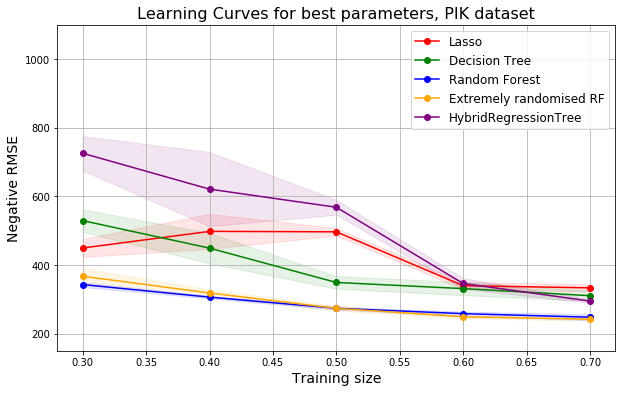

In [58]:
title = "Learning Curves for best parameters, PIK dataset"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)
cv = KFold(n_splits = 3, shuffle = True, random_state = 42)

scoring = make_scorer(rmse)

estimators = [gs_lasso, gs_tree, gs_rf, gs_etr, hrt_etr]
labels = ['Lasso', 'Decision Tree', 'Random Forest', 'Extremely randomised RF', 'HybridRegressionTree']
colors = ['red', 'green', 'blue', 'orange', 'purple']

plot_learning_curve(estimators, labels, colors, title, X, y.values, ylim=(150, 1100), cv=cv, scoring = scoring, n_jobs=1)

# Unfortunately 'learning_curve' function does not support non-sklearn like estimators. 
# So, we will add our methods to the plot manually

### Estimation time

In [62]:
def plot_training_time(estimators, labels, colors,
                        title, 
                        X, y, 
                        ylim=None, 
                        n_jobs=None, 
                        train_sizes=np.linspace(.4, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimators : list, objectS type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    plt.figure(figsize = (10, 6))
    plt.title(title, fontsize = 16)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.yscale("log")
    plt.xlabel("Train size", fontsize = 14)
    plt.ylabel("Time (seconds), log scale", fontsize = 14)
    plt.title(title, fontsize = 16)
    plt.grid()

    for label, estimator, color in zip(labels, estimators, colors):
        train_time = []
        test_time = []
        for size in train_sizes:
            
            size = int(size * len(X))
            t0 = time.time()
            estimator.fit(X[:size], y[:size])
            train_time.append(time.time() - t0)

        plt.plot(train_sizes*X.shape[0], train_time, 'o-', color=color, label=label)


    plt.legend(loc='lower right', fontsize = 12)
    
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\mskuz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

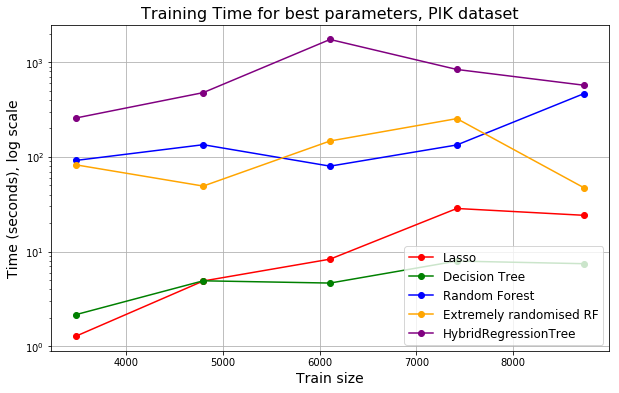

In [64]:
title = "Training Time for best parameters, PIK dataset"
estimators = [gs_lasso, gs_tree, gs_rf, gs_etr, hrt_etr]
labels = ['Lasso', 'Decision Tree', 'Random Forest', 'Extremely randomised RF', 'HybridRegressionTree']
colors = ['red', 'green', 'blue', 'orange', 'purple']

plot_training_time(estimators, labels, colors, title, X, y.values, n_jobs=1)

Никита с тебя 995 в кафе!)